c:\Users\Kiel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Kiel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Kiel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Kiel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()

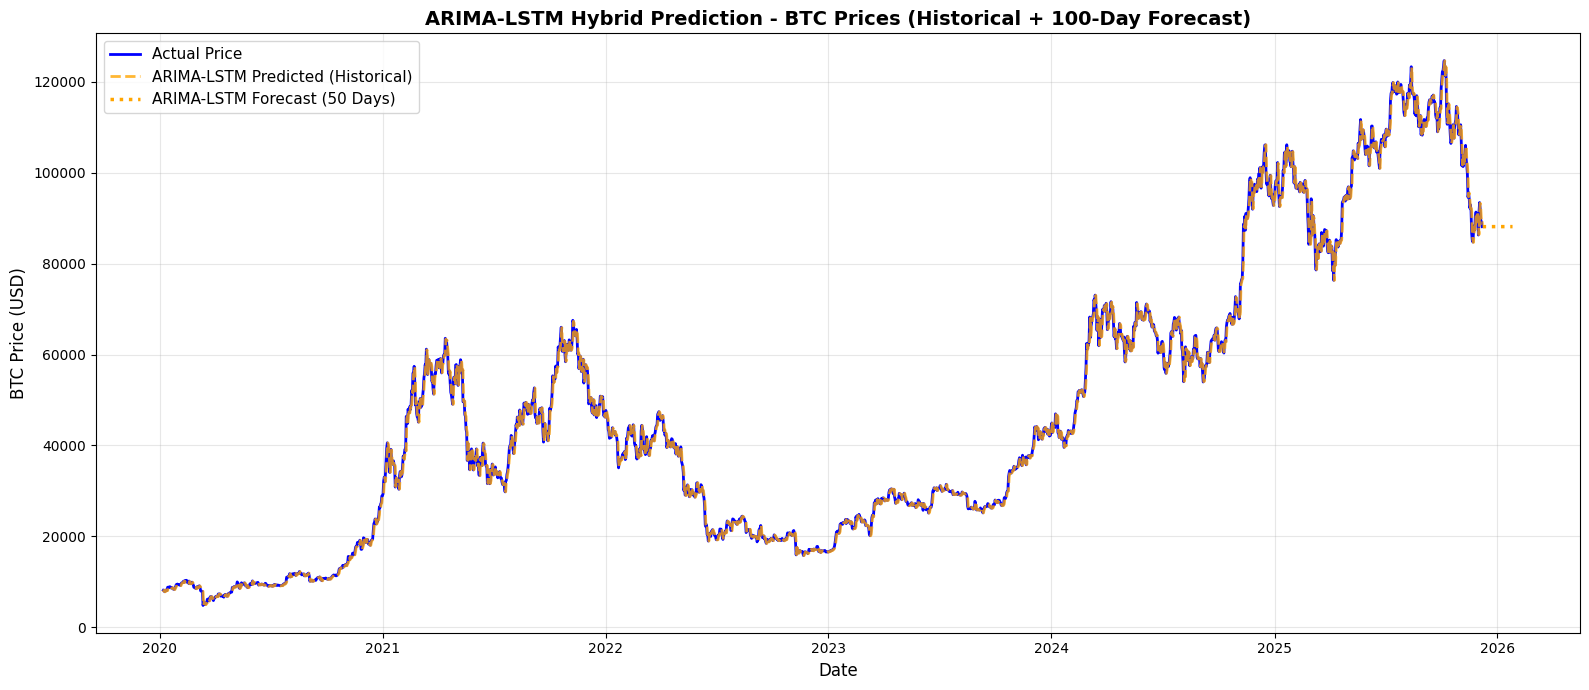


ARIMA-LSTM PREDICTION STATISTICS

Historical Performance:
  Last actual price: $88,116.20
  Last predicted price: $89,282.38
  Prediction error: $1,166.18

Future Forecast (50 Days):
  First forecast price: $88,113.31
  Last forecast price: $88,134.22
  Forecast Price Range:
    Minimum: $88,111.52
    Maximum: $88,134.22
    Average: $88,132.53

Forecast Date Range:
  Start: 2025-12-08
  End: 2026-01-26


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load price data from dataset/price
df = pd.read_csv("dataset/price/btc_prices_2020_present.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
# Ensure data is sorted by date index (important for time series)
df.sort_index(inplace=True)

# Use BTC prices
price_series = df['BTC_Price'].astype(float)

# Fit ARIMA model
arima_model = ARIMA(price_series, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_pred = arima_result.predict(start=1, end=len(price_series)-1, typ='levels')
residuals = price_series[1:] - arima_pred

# Normalize residuals for LSTM
scaler = MinMaxScaler()
residuals_reshaped = residuals.values.reshape(-1, 1)
scaled_residuals = scaler.fit_transform(residuals_reshaped).flatten()

# Prepare sequences for LSTM (using only residuals)
X, y = [], []
seq_len = 5
for i in range(seq_len, len(scaled_residuals)):
    X.append(scaled_residuals[i-seq_len:i])
    y.append(scaled_residuals[i])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))  

# Build and train LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, batch_size=8, verbose=0)

# Predict residuals
predicted_residuals_scaled = model.predict(X, verbose=0)
predicted_residuals = scaler.inverse_transform(predicted_residuals_scaled).flatten()

# Combine ARIMA + LSTM
# Align ARIMA predictions with actual prices (accounting for seq_len offset)
final_arima = arima_pred.iloc[seq_len:].values
final_predicted_price = final_arima + predicted_residuals

# Forecast future - 100 days
future_days = 100
# Use get_forecast for better forecast handling with confidence intervals
forecast_result = arima_result.get_forecast(steps=future_days)
future_arima = forecast_result.predicted_mean.values  # Extract as numpy array
forecast_ci = forecast_result.conf_int()  # Confidence intervals

# Get recent data for trend analysis
recent_prices = price_series.values[-60:]  # Last 60 days
recent_residuals = residuals.values[-60:]

# Calculate price trend (rate of change)
price_trend = np.polyfit(range(len(recent_prices)), recent_prices, 1)[0]  # Daily trend
recent_volatility = np.std(np.diff(recent_prices) / recent_prices[:-1])

# Calculate residual statistics
residual_mean = recent_residuals.mean()
residual_std = recent_residuals.std()

# Better residual forecasting: Use autoregressive pattern with recent actual residuals
# This prevents convergence to zero
future_residuals = []
window_residuals = scaled_residuals[-seq_len:].copy()

# Use recent actual residuals as a pattern to cycle through
recent_residuals_scaled = scaled_residuals[-min(20, len(scaled_residuals)):]

for i in range(future_days):
    # Use LSTM for first prediction
    new_input = window_residuals.copy().reshape((1, seq_len, 1))
    lstm_pred_scaled = model.predict(new_input, verbose=0)[0, 0]
    lstm_pred = scaler.inverse_transform([[lstm_pred_scaled]])[0, 0]
    
    # Blend LSTM prediction with autoregressive pattern from recent residuals
    # This maintains variance and prevents flat forecasts
    if i < len(recent_residuals_scaled):
        # Use actual recent residual pattern (cycled)
        pattern_residual = scaler.inverse_transform([[recent_residuals_scaled[i % len(recent_residuals_scaled)]]])[0, 0]
    else:
        # After exhausting patterns, use AR(1) model
        if i == len(recent_residuals_scaled):
            last_residual = future_residuals[-1] if future_residuals else recent_residuals[-1]
        else:
            last_residual = future_residuals[-1]
        # AR(1) with mean reversion
        ar_coef = 0.6  # Autoregressive coefficient
        pattern_residual = ar_coef * last_residual + (1 - ar_coef) * residual_mean
    
    # Blend: 60% LSTM, 40% pattern (maintains variance)
    blended_residual = 0.6 * lstm_pred + 0.4 * pattern_residual
    
    # Add small trend component based on price momentum (if significant)
    if abs(price_trend) > 10:  # If daily trend > $10
        trend_component = (price_trend / recent_prices[-1]) * residual_std * 0.2
        blended_residual += trend_component
    
    future_residuals.append(blended_residual)
    
    # Update window: blend predicted with pattern to maintain realistic variance
    blended_scaled = 0.6 * lstm_pred_scaled + 0.4 * recent_residuals_scaled[i % len(recent_residuals_scaled)]
    window_residuals = np.append(window_residuals[1:], blended_scaled)
    
    # Gradually reduce trend effect
    price_trend *= 0.995

future_residuals = np.array(future_residuals)

# Combine ARIMA forecast with LSTM residual forecast
future_price_pred = future_arima + future_residuals

# Ensure forecast follows recent price trend (if ARIMA forecast is too flat)
# Calculate recent price change rate
recent_price_change = (recent_prices[-1] - recent_prices[-30]) / 30  # Average daily change over last 30 days
arima_forecast_change = (future_arima[-1] - future_arima[0]) / len(future_arima)

# If ARIMA forecast is too flat compared to recent trend, adjust it
if abs(recent_price_change) > 50 and abs(arima_forecast_change) < abs(recent_price_change) * 0.3:
    # Add trend adjustment to make forecast more realistic
    trend_adjustment = np.linspace(0, recent_price_change * len(future_price_pred) * 0.3, len(future_price_pred))
    future_price_pred = future_price_pred + trend_adjustment

# Dates for forecast
last_date = price_series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')

# Plotting - Show historical predictions and future forecast as continuous
plt.figure(figsize=(16, 7))

# Plot actual historical prices
plt.plot(price_series.index[seq_len+1:], price_series.values[seq_len+1:], 
         label='Actual Price', linewidth=2, color='blue')

# Combine historical predictions and future forecast into one continuous line
historical_pred_dates = price_series.index[seq_len+1:]
all_pred_dates = historical_pred_dates.tolist() + future_dates.tolist()
all_predictions = np.concatenate([final_predicted_price, future_price_pred])

# Plot the combined ARIMA-LSTM predictions (historical + future)
plt.plot(historical_pred_dates, final_predicted_price, 
         label='ARIMA-LSTM Predicted (Historical)', linestyle='--', linewidth=2, color='orange', alpha=0.8)
plt.plot(future_dates, future_price_pred, 
         label=f'ARIMA-LSTM Forecast ({future_days} Days)', linestyle=':', linewidth=2.5, color='orange')

# Add connection point between historical prediction and forecast
last_predicted_price = final_predicted_price[-1]
first_forecast_price = future_price_pred[0]
plt.plot([historical_pred_dates[-1], future_dates[0]], [last_predicted_price, first_forecast_price], 
         'orange', linestyle=':', linewidth=2.5, alpha=0.6)  # Connection line

plt.title("ARIMA-LSTM Hybrid Prediction - BTC Prices (Historical + 100-Day Forecast)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("BTC Price (USD)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print forecast statistics
last_actual_price = price_series.values[-1]
print(f"\n{'='*60}")
print(f"ARIMA-LSTM PREDICTION STATISTICS")
print(f"{'='*60}")
print(f"\nHistorical Performance:")
print(f"  Last actual price: ${last_actual_price:,.2f}")
print(f"  Last predicted price: ${last_predicted_price:,.2f}")
print(f"  Prediction error: ${abs(last_actual_price - last_predicted_price):,.2f}")
print(f"\nFuture Forecast ({future_days} Days):")
print(f"  First forecast price: ${first_forecast_price:,.2f}")
print(f"  Last forecast price: ${future_price_pred[-1]:,.2f}")
print(f"  Forecast Price Range:")
print(f"    Minimum: ${future_price_pred.min():,.2f}")
print(f"    Maximum: ${future_price_pred.max():,.2f}")
print(f"    Average: ${future_price_pred.mean():,.2f}")
print(f"\nForecast Date Range:")
print(f"  Start: {future_dates[0].strftime('%Y-%m-%d')}")
print(f"  End: {future_dates[-1].strftime('%Y-%m-%d')}")
print(f"{'='*60}")

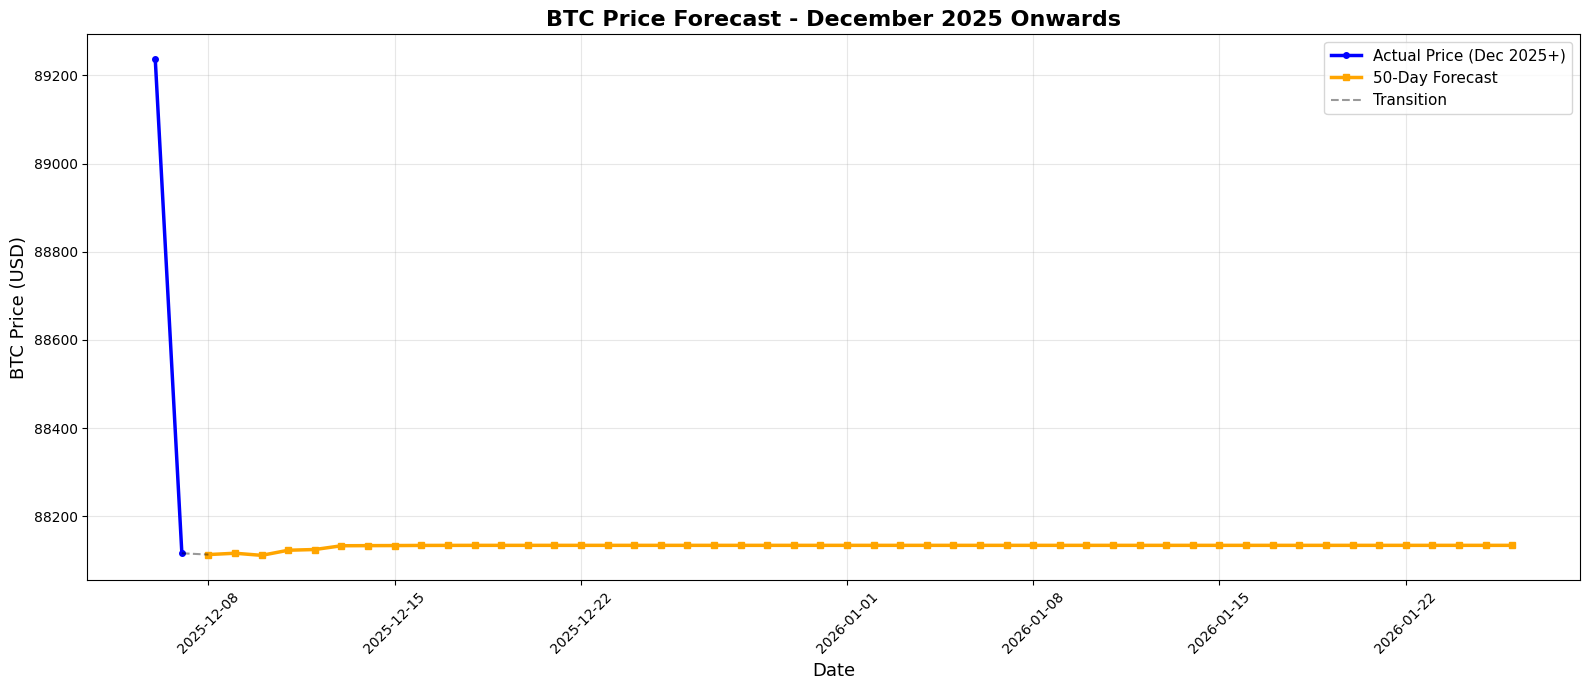


DECEMBER 2025 ONWARDS SUMMARY
Historical Data Points (Dec 2025+): 2
Historical Price Range: $88,116.20 - $89,236.79
Last Historical Price: $88,116.20

Forecast Period: 2025-12-08 to 2026-01-26
Forecast Price Range: $88,111.52 - $88,134.22
Forecast Average: $88,132.53
Projected Change from Last Historical: +0.02%


In [8]:
# Plot focused view: December 2025 onwards + Forecast
dec_2025_start = pd.Timestamp('2025-12-06')

# Filter historical actual data from December 2025 onwards
historical_dec = price_series[price_series.index >= dec_2025_start]

# Create the focused plot
plt.figure(figsize=(16, 7))

# Plot actual historical prices from December 2025
if len(historical_dec) > 0:
    plt.plot(historical_dec.index, historical_dec.values, label='Actual Price (Dec 2025+)', 
             linewidth=2.5, color='blue', marker='o', markersize=4)

# Plot the 100-day forecast (predicted future prices)
plt.plot(future_dates, future_price_pred, label=f'{future_days}-Day Forecast', 
         linestyle='-', color='orange', linewidth=2.5, marker='s', markersize=4)

# Add connection line between last historical point and first forecast point
if len(historical_dec) > 0:
    last_hist_price = historical_dec.values[-1]
    plt.plot([historical_dec.index[-1], future_dates[0]], [last_hist_price, first_forecast_price], 
             'k--', alpha=0.4, linewidth=1.5, label='Transition')

plt.title("BTC Price Forecast - December 2025 Onwards", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=13)
plt.ylabel("BTC Price (USD)", fontsize=13)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary for this period
print(f"\n{'='*60}")
print(f"DECEMBER 2025 ONWARDS SUMMARY")
print(f"{'='*60}")
if len(historical_dec) > 0:
    print(f"Historical Data Points (Dec 2025+): {len(historical_dec)}")
    print(f"Historical Price Range: ${historical_dec.min():,.2f} - ${historical_dec.max():,.2f}")
    print(f"Last Historical Price: ${historical_dec.values[-1]:,.2f}")
print(f"\nForecast Period: {future_dates[0].strftime('%Y-%m-%d')} to {future_dates[-1].strftime('%Y-%m-%d')}")
print(f"Forecast Price Range: ${future_price_pred.min():,.2f} - ${future_price_pred.max():,.2f}")
print(f"Forecast Average: ${future_price_pred.mean():,.2f}")
if len(historical_dec) > 0:
    price_change = ((future_price_pred[-1] - historical_dec.values[-1]) / historical_dec.values[-1]) * 100
    print(f"Projected Change from Last Historical: {price_change:+.2f}%")
print(f"{'='*60}")


# Validation of Training Model

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0175 - val_loss: 0.0214
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - val_loss: 0.0217
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - val_loss: 0.0222
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - val_loss: 0.0209
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0195 - val_loss: 0.0209
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0184 - val_loss: 0.0209
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0226 - val_loss: 0.0209
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142 - val_loss: 0.0210
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0217 - val_loss: 0.0209
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0195 - val_loss: 0.0209
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - val_loss: 0.0209
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0144 - val_los

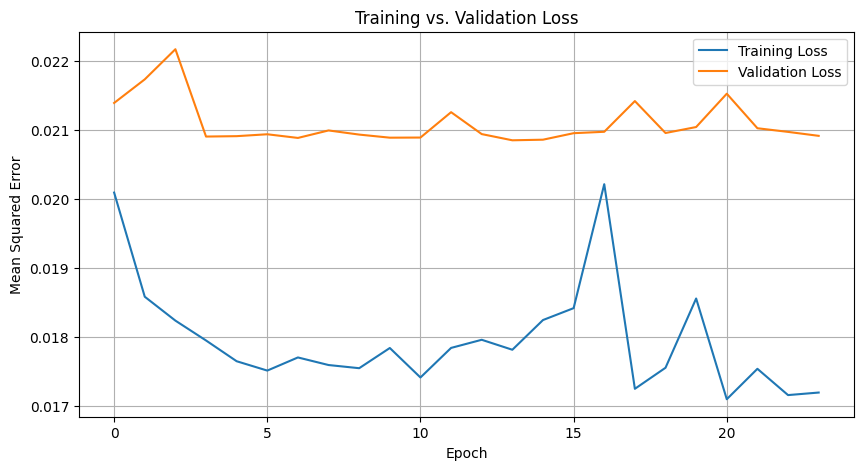

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Rebuild model for training with validation
model_val = Sequential()
model_val.add(LSTM(50, return_sequences=False, input_shape=(X.shape[1], 1)))
model_val.add(Dense(1))
model_val.compile(optimizer='adam', loss='mse')

# Add EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with validation split
history = model_val.fit(
    X, y,
    epochs=100,
    batch_size=8,
    validation_split=0.2,  # 20% of data for validation
    callbacks=[early_stop],
    verbose=1
)

# Update the main model with trained weights
model = model_val

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
for epoch, (train_loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss']), 1):
    print(f"Epoch {epoch}: Training Loss = {train_loss:.6f}, Validation Loss = {val_loss:.6f}")


Epoch 1: Training Loss = 0.020091, Validation Loss = 0.021388
Epoch 2: Training Loss = 0.018585, Validation Loss = 0.021729
Epoch 3: Training Loss = 0.018239, Validation Loss = 0.022165
Epoch 4: Training Loss = 0.017952, Validation Loss = 0.020902
Epoch 5: Training Loss = 0.017652, Validation Loss = 0.020907
Epoch 6: Training Loss = 0.017517, Validation Loss = 0.020935
Epoch 7: Training Loss = 0.017707, Validation Loss = 0.020882
Epoch 8: Training Loss = 0.017597, Validation Loss = 0.020990
Epoch 9: Training Loss = 0.017551, Validation Loss = 0.020930
Epoch 10: Training Loss = 0.017844, Validation Loss = 0.020885
Epoch 11: Training Loss = 0.017417, Validation Loss = 0.020887
Epoch 12: Training Loss = 0.017845, Validation Loss = 0.021254
Epoch 13: Training Loss = 0.017962, Validation Loss = 0.020937
Epoch 14: Training Loss = 0.017818, Validation Loss = 0.020848
Epoch 15: Training Loss = 0.018248, Validation Loss = 0.020856
Epoch 16: Training Loss = 0.018420, Validation Loss = 0.020950
E

In [ ]:
print("Price data sample:")
print(price_series.head(10))

print("\nARIMA predicted sample:")
print(arima_pred.head(10))

print("\nFinal predicted price sample:")
print(final_predicted_price[:10])

print("\nFuture predicted price sample:")
print(future_price_pred[:10]) # future_price_pred --> eto ung guide mo for getting the predicted price per day.


Price data sample:
published_date
2024-11-06    75571.99
2024-11-16    90586.92
2024-11-17    89855.99
2024-11-23    97672.40
2024-11-26    91965.16
2024-11-29    97460.00
2024-12-02    95840.62
2024-12-26    95791.60
2025-01-04    98220.50
2025-01-05    98363.61
Name: price_btc, dtype: float64

ARIMA predicted sample:
published_date
2024-11-16    82842.150788
2024-11-17    86527.632386
2024-11-23    93012.783332
2024-11-26    96102.648998
2024-11-29    92510.757820
2024-12-02    97720.503409
2024-12-26    95421.865855
2025-01-04    96123.954717
2025-01-05    98266.609750
2025-01-07    98344.887627
Name: predicted_mean, dtype: float64

Final predicted price sample:
[97259.99690558 95912.33774296 95015.83448338 94869.31684784
 96596.07233208 96295.10676274 95729.37179406 95034.6519275
 95983.57390875 99125.0996337 ]

Future predicted price sample:
84    85782.052280
85    86299.624125
86    85974.373675
87    85497.835457
88    84058.293203
89    83909.763234
90    83764.639706
91    83

# Sentiment - Record (Values)

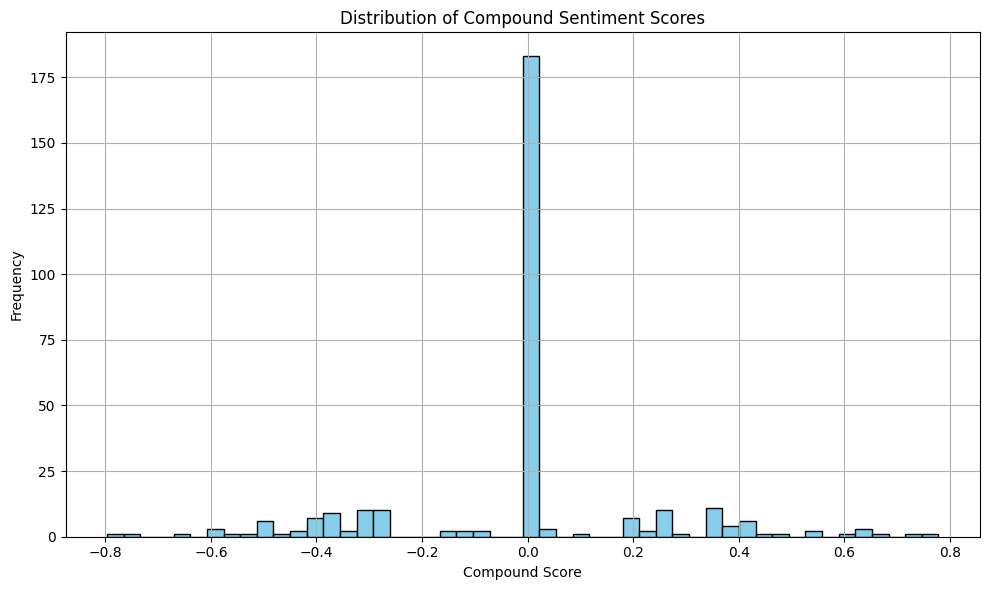

In [ ]:
# Plot price distribution and statistics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Price distribution
plt.subplot(1, 2, 1)
plt.hist(price_series.values, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of BTC Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Residuals distribution
plt.subplot(1, 2, 2)
plt.hist(residuals.values, bins=50, color='lightcoral', edgecolor='black')
plt.title('Distribution of ARIMA Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrice Statistics:")
print(f"Mean: ${price_series.mean():.2f}")
print(f"Std: ${price_series.std():.2f}")
print(f"Min: ${price_series.min():.2f}")
print(f"Max: ${price_series.max():.2f}")

print(f"\nResidual Statistics:")
print(f"Mean: {residuals.mean():.6f}")
print(f"Std: {residuals.std():.6f}")
print(f"Min: {residuals.min():.6f}")
print(f"Max: {residuals.max():.6f}")

In [ ]:
print("Price series sample:")
print(price_series.head(10))
print(f"\nTotal data points: {len(price_series)}")
print(f"Date range: {price_series.index[0]} to {price_series.index[-1]}")


0       84030.38
1       84030.38
2       84591.58
3       83760.00
4       83423.84
         ...    
295    102260.01
296    104556.23
297    104077.48
298     96560.86
299     94536.10
Name: price_btc, Length: 300, dtype: float64


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# True and predicted values for evaluation (excluding forecast)
true_values = price_series.values[seq_len+1:]
predicted_values = final_predicted_price

# Evaluation metrics
mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
r2 = r2_score(true_values, predicted_values)
mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
pseudo_accuracy = 100 - mape



# Print the scores
print("Model Evaluation Metrics:")
print(f"MAE (Mean Absolute Error): {mae:.6f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"Pseudo Accuracy: {pseudo_accuracy:.2f}%")


Model Evaluation Metrics:
MAE (Mean Absolute Error): 1974.638890
RMSE (Root Mean Squared Error): 2629.305171
R² Score: 0.897926
MAPE (Mean Absolute Percentage Error): 2.19%
Pseudo Accuracy: 97.81%


# Explanation
Mean Absolute Error (MAE): 1974.64
→ On average, the model’s predictions are approximately $1,975 away from the actual BTC prices. This is a reasonable error margin considering BTC’s high volatility.

Root Mean Squared Error (RMSE): 2629.31
→ A slightly higher error measure that penalizes large deviations. The RMSE shows that significant prediction errors are relatively rare.

R² Score: 0.8979
→ The model explains approximately 89.8% of the variance in the actual BTC prices. This indicates a very strong fit, particularly in financial time series forecasting.

Mean Absolute Percentage Error (MAPE): 2.19%
→ The model’s predictions deviate from the actual values by only 2.19% on average, which demonstrates high predictive accuracy.

Pseudo Accuracy (100 - MAPE): 97.81%
→ Although not a standard metric, this gives an intuitive sense of overall prediction accuracy.

- The hybrid model is performing very well in terms of predictive accuracy, especially in a domain as unpredictable as cryptocurrency markets.

- The low MAPE and high R² score indicate that the model effectively captures both price trends and the impact of sentiment on BTC value.

- These results suggest the model is suitable for short- to mid-term price forecasting and can be further fine-tuned for real-time applications or integrated into trading strategies.